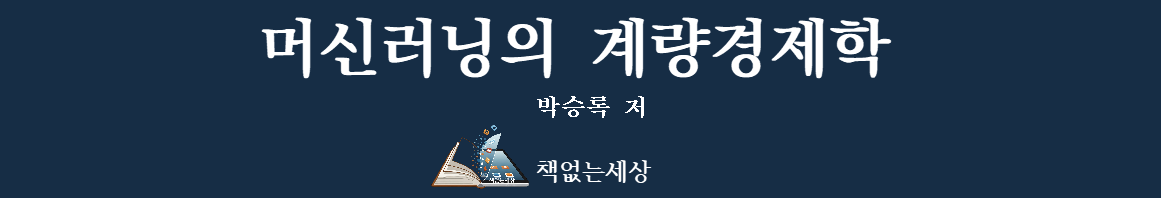

# Part 5: 정성적 선택모형, 제한 종속변수 모형

## Chapter 1. 정성적 선택모형

In [1]:
# 작업공간(working directory)지정  
import os  
os.chdir("X:/Econometrics_with_ML")
os.getcwd()

'X:\\Econometrics_with_ML'

In [2]:
# exec(open('X:/Econometrics_with_ML/Functions/Traditional_Econometrics_Lib.py').read())

In [3]:
# 전통적 계량경제학에서 자주 사용되는 라이브러리(Libraries for the Analysis of Traditional Econometrics)
# Call this file 
# "exec(open('Functions/Traditional_Econometrics_Lib.py').read())"
# "%run –i Functions/Traditional_Econometrics_Lib.py"
# "from Functions.Traditional_Econometrics_Lib import * "

import os
import numpy as np                                       # Numerical calculations
import pandas as pd                                      # Data handling
import math as someAlias
import matplotlib.dates as mdates                        # Turn dates into numbers
import matplotlib.pyplot as plt                          # Lower-level graphics
import patsy as pt
import seaborn as sns
import stargazer as sg
import statsmodels.api as sm
import statsmodels.formula.api as smf                    # Econometrics
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.outliers_influence as smo
import linearmodels as lm                                # Panel model, Simultaneous Eq. Model
import scipy.stats as stats                              # Statistics
import random
from scipy.optimize import Bounds
from scipy.optimize import curve_fit                    # Nonlinear regression
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.graphics import tsaplots               # Time series
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller          # ADF test
from statsmodels.tsa.stattools import coint             # Cointegration
from statsmodels.tsa.vector_ar.vecm import VECM
from arch import arch_model
import wooldridge as woo
import wbdata
import warnings
warnings.filterwarnings("ignore")

# Korean Fonts
import matplotlib as mpl
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

### 라. 파이썬에서 프로빗 모형과 로짓 모형의 추정 

In [4]:
import wooldridge as woo
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats

# 데이터 읽어들이기
mroz = woo.dataWoo('mroz')
equation = 'inlf ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6'

# 선형확률모형(linear probability model)의 추정
reg_lin = smf.ols(formula=equation, data=mroz)
results_lin = reg_lin.fit(cov_type='HC3')
print(results_lin.summary())

# 로짓모형(logit model)의 추정
reg_logit = smf.logit(formula= equation, data=mroz)
results_logit = reg_logit.fit()
print(results_logit.summary())

# 프로빗 모형(probit model)
reg_probit = smf.probit(formula=equation, data=mroz)
results_probit = reg_probit.fit(disp=0)
print(results_probit.summary())


                            OLS Regression Results                            
Dep. Variable:                   inlf   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     61.35
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           1.55e-69
Time:                        18:17:08   Log-Likelihood:                -423.89
No. Observations:                 753   AIC:                             863.8
Df Residuals:                     745   BIC:                             900.8
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5855      0.154      3.812

In [5]:
# 전반적 유의성 검정(test of overall significance)
llr1_manual = 2 * (results_probit.llf - results_probit.llnull)
print(f'llr1_manual: {llr1_manual}\n')
print(f'results_probit.llr: {results_probit.llr}\n')
print(f'results_probit.llr_pvalue: {results_probit.llr_pvalue}\n')

# 제약조건의 검정을 위한 왈드테스트(Wald test)
# H0: experience and age 변수는 무관한 변수
hypotheses = ['exper=0', 'I(exper ** 2)=0', 'age=0']
waldstat = results_probit.wald_test(hypotheses)
teststat2_autom = waldstat.statistic
pval2_autom = waldstat.pvalue
print(f'teststat2_autom: {teststat2_autom}\n')
print(f'pval2_autom: {pval2_autom}\n')


llr1_manual: 227.14202283719237

results_probit.llr: 227.14202283719237

results_probit.llr_pvalue: 2.0086732957627125e-45

teststat2_autom: [[110.91852003]]

pval2_autom: 6.960738406731183e-24



In [6]:
# 특별한 관측치 정의후 예측
X_new = pd.DataFrame(
    {'nwifeinc': [100, 0], 'educ': [5, 17], 'exper': [0, 30], 
     'age': [20, 52], 'kidslt6': [2, 0], 'kidsge6': [0, 0]})
predictions_lin = results_lin.predict(X_new)
predictions_logit = results_logit.predict(X_new)
predictions_probit = results_probit.predict(X_new)

print(f'predictions_lin: \n{predictions_lin}\n')
print(f'predictions_logit: \n{predictions_logit}\n')
print(f'predictions_probit: \n{predictions_probit}\n')

predictions_lin: 
0   -0.410458
1    1.042808
dtype: float64

predictions_logit: 
0    0.005218
1    0.950049
dtype: float64

predictions_probit: 
0    0.001065
1    0.959870
dtype: float64



In [7]:
# 평균 한계효과의 측정 (manual average partial effects)
APE_lin = np.array(results_lin.params)

xb_logit = results_logit.fittedvalues
factor_logit = np.mean(stats.logistic.pdf(xb_logit))
APE_logit_manual = results_logit.params * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = np.mean(stats.norm.pdf(xb_probit))
APE_probit_manual = results_probit.params * factor_probit

table_manual = pd.DataFrame({'APE_lin': np.round(APE_lin, 4),
                             'APE_logit_manual': np.round(APE_logit_manual, 4),
                             'APE_probit_manual': np.round(APE_probit_manual, 4)})
print(f'table_manual: \n{table_manual}\n')

# 함수를 이용한 평균한계효과의 측정
coef_names = np.array(results_lin.model.exog_names)
coef_names = np.delete(coef_names, 0)  # drop Intercept

APE_logit_autom = results_logit.get_margeff().margeff
APE_probit_autom = results_probit.get_margeff().margeff

table_auto = pd.DataFrame({'coef_names': coef_names,
                           'APE_logit_autom': np.round(APE_logit_autom, 4),
                           'APE_probit_autom': np.round(APE_probit_autom, 4)})
print(f'table_auto: \n{table_auto}\n')


table_manual: 
               APE_lin  APE_logit_manual  APE_probit_manual
Intercept       0.5855            0.0760             0.0812
nwifeinc       -0.0034           -0.0038            -0.0036
educ            0.0380            0.0395             0.0394
exper           0.0395            0.0368             0.0371
I(exper ** 2)  -0.0006           -0.0006            -0.0006
age            -0.0161           -0.0157            -0.0159
kidslt6        -0.2618           -0.2578            -0.2612
kidsge6         0.0130            0.0107             0.0108

table_auto: 
      coef_names  APE_logit_autom  APE_probit_autom
0       nwifeinc          -0.0038           -0.0036
1           educ           0.0395            0.0394
2          exper           0.0368            0.0371
3  I(exper ** 2)          -0.0006           -0.0006
4            age          -0.0157           -0.0159
5        kidslt6          -0.2578           -0.2612
6        kidsge6           0.0107            0.0108



### 5) 몬테칼로 실험을 통한 선형 확률모형, 로짓 모형, 프로빗 모형 추정

In [8]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as stats

# Random seed:
np.random.seed(1234567)

y = stats.binom.rvs(1, 0.5, size=100)
X = stats.norm.rvs(0, 1, size=100) + 2 * y
sim_data = pd.DataFrame({'y': y, 'X': X})

# 선형확률 모형의 추정
reg_lin = smf.ols(formula='y ~ X', data=sim_data)
results_lin = reg_lin.fit()
print(results_lin.summary())

#, 로짓모형의 추정
reg_logit = smf.logit(formula='y ~ X', data=sim_data)
results_logit = reg_logit.fit(disp=0)
print(results_logit.summary())

# 프로빗 모형의 추정
reg_probit = smf.probit(formula='y ~ X', data=sim_data)
results_probit = reg_probit.fit(disp=0)
print(results_probit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     104.4
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           4.08e-17
Time:                        18:17:08   Log-Likelihood:                -34.667
No. Observations:                 100   AIC:                             73.33
Df Residuals:                      98   BIC:                             78.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1698      0.042      4.062      0.0

In [9]:
# 한계효과(partial effects)의 계산
PE_lin = np.repeat(results_lin.params['X'], 100)

Xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(Xb_logit)
PE_logit = results_logit.params['X'] * factor_logit

Xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(Xb_probit)
PE_probit = results_probit.params['X'] * factor_probit
Partial1 = pd.DataFrame(data = [X, PE_lin, PE_logit, PE_probit], index = ["X", "LPM", "Logit", "Probit"]).T
print(Partial1)


           X       LPM     Logit    Probit
0  -0.347438  0.268804  0.059217  0.059822
1  -1.300040  0.268804  0.007021  0.001925
2   1.210626  0.268804  0.571954  0.528997
3   0.850885  0.268804  0.478487  0.467262
4  -1.261498  0.268804  0.007664  0.002282
..       ...       ...       ...       ...
95  2.025416  0.268804  0.272678  0.301969
96  1.917234  0.268804  0.323647  0.347929
97  0.206200  0.268804  0.184386  0.211658
98  1.967921  0.268804  0.299272  0.326419
99 -1.709153  0.268804  0.002763  0.000270

[100 rows x 4 columns]


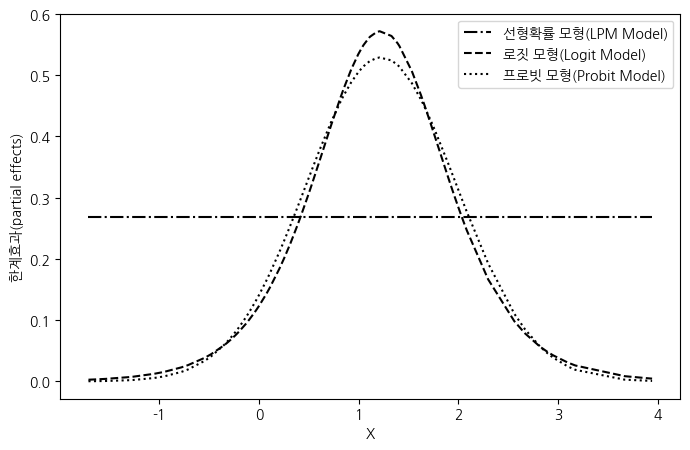

In [10]:
Partial2 = Partial1.sort_values(by='X', ascending=True)

plt.figure(figsize =(8, 5))
plt.plot(Partial2['X'], Partial2['LPM'], linestyle='-.', color='black', label='선형확률 모형(LPM Model)')
plt.plot(Partial2['X'], Partial2['Logit'], linestyle='--', color='black', label='로짓 모형(Logit Model)')
plt.plot(Partial2['X'], Partial2['Probit'], linestyle=':', color='black', label='프로빗 모형(Probit Model)')
plt.ylabel('한계효과(partial effects)')
plt.xlabel('X')
plt.legend()
plt.show()


In [11]:
# 예측(prediction)
X_new = pd.DataFrame({'X': np.linspace(min(X), max(X), 50)})
predictions_lin = results_lin.predict(X_new)
predictions_logit = results_logit.predict(X_new)
predictions_probit = results_probit.predict(X_new)

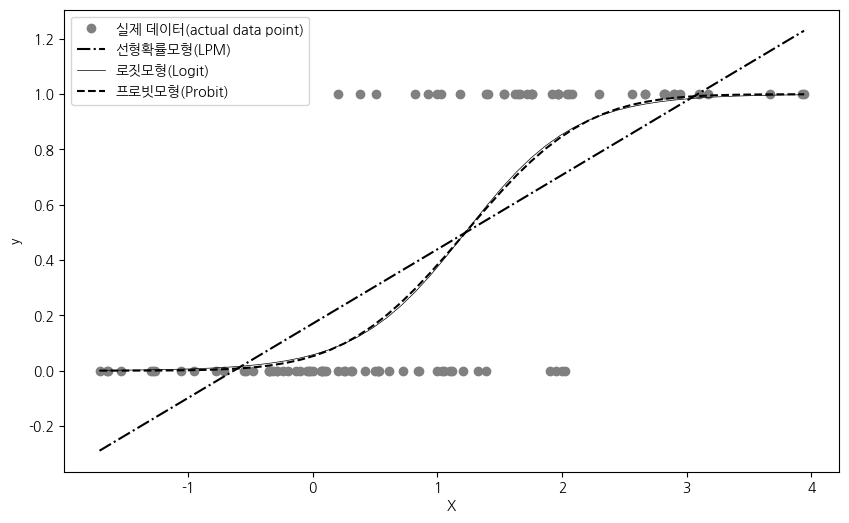

In [12]:
# 그래프 그리기
plt.figure(figsize =(10, 6))
plt.plot(X, y, color='grey', marker='o', linestyle='', label='실제 데이터(actual data point)')
plt.plot(X_new['X'], predictions_lin,
         color='black', linestyle='-.', label='선형확률모형(LPM)')
plt.plot(X_new['X'], predictions_logit,
         color='black', linestyle='-', linewidth=0.5, label='로짓모형(Logit)')
plt.plot(X_new['X'], predictions_probit,
         color='black', linestyle='--', label='프로빗모형(Probit)')
plt.ylabel('y')
plt.xlabel('X')
plt.legend(loc = 'upper left')
#plt.savefig('PyGraphs/Binary-Predictions.pdf')

## 3. 다항 회귀 모형(multinomial regression model)

### 가. 다항 로짓 모형

In [13]:
# 데이터 읽어들이기
df = pd.read_csv('Data/nels_small.csv')
display(df) 

# 다항로짓모형의 추정(설명변수는 선택자의 특징을 나타내는 자료이어야 함)
mlogit = smf.mnlogit('psechoice ~ hscath + grades + faminc + famsiz + parcoll + female + black', data=df)
results_ML = mlogit.fit()
print(results_ML.summary())

# 한계효과 계산
me = results_ML.get_margeff(at= 'mean', method = 'dydx')
print(me.summary())

,psechoice,hscath,grades,faminc,famsiz,parcoll,female,black
0,2,0,9.08,62.5,5,0,0,0
1,2,0,8.31,42.5,4,0,1,0
2,3,0,7.42,62.5,4,0,1,0
3,3,0,7.42,62.5,4,0,1,0
4,3,0,7.42,62.5,4,0,1,0
...,...,...,...,...,...,...,...,...
995,2,0,8.13,62.5,4,0,0,0
996,3,0,5.28,87.5,6,0,1,0
997,1,0,7.54,30.0,5,0,1,0
998,3,0,3.64,42.5,5,0,1,0


         Current function value: 0.829747
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:              psechoice   No. Observations:                 1000
Model:                        MNLogit   Df Residuals:                      984
Method:                           MLE   Df Model:                           14
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                  0.1855
Time:                        18:17:09   Log-Likelihood:                -829.75
converged:                      False   LL-Null:                       -1018.7
Covariance Type:            nonrobust   LLR p-value:                 5.904e-72
psechoice=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2688      0.578      3.924      0.000       1.135       3.402
hscath         -6.0184   3.54e+05   -1.7e-05      1.000   -6.9

## 나. 조건부 로짓 모형; 다. 혼합로짓 모형

In [14]:
# 조건부로짓, 혼합로짓 모형의 추정
from statsmodels.discrete.conditional_models import ConditionalLogit

# 데이터 읽어들이기
df = pd.read_csv('data/transp.csv')
display(df) 

# 조건부 로짓모형의 추정(설명변수는 선택대안의 특징을 나타내는 자료이어야 함)
y =  df['choice']
X = df[['termtime', 'invehiclecost', 'traveltime', 'travelcost', 'air', 'train', 'bus']]
id = df['id']

cl_model = ConditionalLogit(endog = y, exog = X, groups = id)
results_CL = cl_model.fit()
print(results_CL.summary())

# 혼합로짓모형(설명변수는  선택자 & 선택대안의 특징적 자료가 혼합)
df['incair'] =  df['income']* df['air']
df['inctra'] = df['income']* df['train']
df['incbus'] = df['income']* df['bus']
df['parair'] = df['partysize']* df['air']
df['partra'] = df['partysize']* df['train']
df['parbus'] = df['partysize']* df['bus']

# 조건부 로짓모형의 추정()
y =  df['choice']
X = df[['termtime', 'invehiclecost', 'traveltime', 'travelcost', 'air', 'train', 'bus',
       'incair', 'inctra', 'incbus', 'parair', 'partra', 'parbus']]
id = df['id']

mx_model = ConditionalLogit(endog = y, exog = X, groups = id)
results_MX = mx_model.fit()
print(results_MX.summary())

,id,mode,choice,termtime,invehiclecost,traveltime,travelcost,income,partysize,air,train,bus,car
0,1,1,0,69,59,100,70,35,1,1,0,0,0
1,1,2,0,34,31,372,71,35,1,0,1,0,0
2,1,3,0,35,25,417,70,35,1,0,0,1,0
3,1,4,1,0,10,180,30,35,1,0,0,0,1
4,2,1,0,64,58,68,68,30,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,209,4,1,0,27,510,82,20,1,0,0,0,1
836,210,1,0,64,66,140,87,70,4,1,0,0,0
837,210,2,0,44,54,670,156,70,4,0,1,0,0
838,210,3,0,53,33,664,134,70,4,0,0,1,0


                  Conditional Logit Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                  840
Model:               ConditionalLogit   No. groups:                        210
Log-Likelihood:               -184.51   Min group size:                      4
Method:                          BFGS   Max group size:                      4
Date:                Mon, 18 Aug 2025   Mean group size:                   4.0
Time:                        18:17:10                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
termtime         -0.1036      0.011     -9.476      0.000      -0.125      -0.082
invehiclecost    -0.0849      0.019     -4.382      0.000      -0.123      -0.047
traveltime       -0.0133      0.003     -5.297      0.000      -0.018      -0.008
travelcost        0.0693      0.017  

## 라. 서열 로짓, 서열 프로빗 모형 

In [15]:
# 서열로짓, 서열프로빗 모형의 추정
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel

# 데이터 읽어들이기
df = pd.read_csv('data/warm.csv')
display(df) 

y =  df['warm']
X = df[['yr89', 'male', 'white', 'age', 'ed', 'prst']]
 
mod_prob = OrderedModel(endog=y, exog = X, distr='probit')
res_prob = mod_prob.fit(method='bfgs')
print(res_prob.summary())

mod_logit = OrderedModel(endog=y, exog = X, distr='logit')
res_logit = mod_logit.fit(method='bfgs')
print(res_logit.summary())

,warm,yr89,male,white,age,ed,prst,warmlt2,warmlt3,warmlt4
0,1,0,0,1,33,10,31,1,1,1
1,1,0,1,1,74,16,50,1,1,1
2,1,1,1,1,36,12,41,1,1,1
3,1,0,0,1,73,9,36,1,1,1
4,1,0,0,1,59,11,62,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2288,4,1,1,1,30,10,47,0,0,0
2289,4,0,0,1,55,11,46,0,0,0
2290,4,1,0,1,39,17,63,0,0,0
2291,4,1,0,0,55,14,36,0,0,0


Optimization terminated successfully.
         Current function value: 1.242307
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:                   warm   Log-Likelihood:                -2848.6
Model:                   OrderedModel   AIC:                             5715.
Method:            Maximum Likelihood   BIC:                             5767.
Date:                Mon, 18 Aug 2025                                         
Time:                        18:17:11                                         
No. Observations:                2293                                         
Df Residuals:                    2284                                         
Df Model:                           6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------